In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d almightyj/person-face-sketches

Dataset URL: https://www.kaggle.com/datasets/almightyj/person-face-sketches
License(s): CC0-1.0
 99% 1.27G/1.29G [00:11<00:00, 228MB/s]
100% 1.29G/1.29G [00:11<00:00, 121MB/s]


In [7]:
!unzip person-face-sketches.zip -d dataset/

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/sketches/6061.jpg  
  inflating: dataset/train/sketches/6062.jpg  
  inflating: dataset/train/sketches/6063.jpg  
  inflating: dataset/train/sketches/6064.jpg  
  inflating: dataset/train/sketches/6065.jpg  
  inflating: dataset/train/sketches/6066.jpg  
  inflating: dataset/train/sketches/6067.jpg  
  inflating: dataset/train/sketches/6068.jpg  
  inflating: dataset/train/sketches/6069.jpg  
  inflating: dataset/train/sketches/607.jpg  
  inflating: dataset/train/sketches/6070.jpg  
  inflating: dataset/train/sketches/6071.jpg  
  inflating: dataset/train/sketches/6072.jpg  
  inflating: dataset/train/sketches/6073.jpg  
  inflating: dataset/train/sketches/6074.jpg  
  inflating: dataset/train/sketches/6075.jpg  
  inflating: dataset/train/sketches/6076.jpg  
  inflating: dataset/train/sketches/6077.jpg  
  inflating: dataset/train/sketches/6078.jpg  
  inflating: dataset/train/sketches/6079.jpg  
  inflatin

In [9]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class FaceSketchDataset(Dataset):
    def __init__(self, sketch_dir, real_dir, transform=None):
        self.sketch_dir = sketch_dir
        self.real_dir = real_dir
        self.transform = transform
        self.sketches = os.listdir(self.sketch_dir)
        self.reals = os.listdir(self.real_dir)

    def __len__(self):
        return len(self.sketches)

    def __getitem__(self, idx):
        sketch_path = os.path.join(self.sketch_dir, self.sketches[idx])
        real_path = os.path.join(self.real_dir, self.reals[idx])

        sketch = Image.open(sketch_path).convert('RGB')  # grayscale
        real = Image.open(real_path).convert('RGB')  # real image in color

        if self.transform:
            sketch = self.transform(sketch)
            real = self.transform(real)

        return sketch, real

# Transform for preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

# Load dataset
sketch_dir = 'dataset/train/sketches'
real_dir = 'dataset/train/photos'
dataset = FaceSketchDataset(sketch_dir, real_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import itertools

# Define Generator Network (using ResNet blocks)
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, num_residual_blocks=9):
        super(Generator, self).__init__()
        # Initial Convolution Block
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        # Downsampling
        self.downsampling = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )
        # Residual Blocks
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(256) for _ in range(num_residual_blocks)]
        )
        # Upsampling
        self.upsampling = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        # Final Output Layer
        self.output = nn.Conv2d(64, out_channels, kernel_size=7, stride=1, padding=3)

    def forward(self, x):
        x = self.initial(x)
        x = self.downsampling(x)
        x = self.residual_blocks(x)
        x = self.upsampling(x)
        return torch.tanh(self.output(x))

# Define Discriminator Network (PatchGAN)
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Define loss functions
criterion_gan = nn.MSELoss()  # Adversarial loss
criterion_cycle = nn.L1Loss()  # Cycle consistency loss
criterion_identity = nn.L1Loss()  # Identity loss

# Initialize models
G = Generator().to(device)
F = Generator().to(device)
D_X = Discriminator().to(device)
D_Y = Discriminator().to(device)

# Optimizers
optimizer_G = optim.Adam(itertools.chain(G.parameters(), F.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_X = optim.Adam(D_X.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_Y = optim.Adam(D_Y.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [16]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def denormalize(tensor):
    """
    Denormalizes a tensor image.

    Args:
    - tensor (Tensor): Normalized image tensor.

    Returns:
    - Tensor: Denormalized image tensor.
    """
    # Assuming normalization was done with mean=[0.5] and std=[0.5]
    tensor = tensor * 0.5 + 0.5  # Scale from [-1, 1] to [0, 1]
    return tensor.clamp(0, 1)  # Ensure values are within [0, 1]

def show_images(real_A, real_B, fake_A, fake_B, num_images=4):
    """
    Displays real and fake images from the current batch.

    Args:
    - real_A (Tensor): Batch of real photos.
    - real_B (Tensor): Batch of real sketches.
    - fake_A (Tensor): Batch of generated photos from sketches.
    - fake_B (Tensor): Batch of generated sketches from photos.
    - num_images (int): Number of images to display.
    """
    real_A = real_A[:num_images].cpu()
    real_B = real_B[:num_images].cpu()
    fake_A = fake_A[:num_images].detach().cpu()
    fake_B = fake_B[:num_images].detach().cpu()

    # Denormalize images
    real_A = denormalize(real_A)
    real_B = denormalize(real_B)
    fake_A = denormalize(fake_A)
    fake_B = denormalize(fake_B)

    fig, axes = plt.subplots(num_images, 4, figsize=(12, 3 * num_images))
    for i in range(num_images):
        # Real Photo
        axes[i, 0].imshow(transforms.ToPILImage()(real_A[i]))
        axes[i, 0].set_title("Real Photo")
        axes[i, 0].axis("off")

        # Real Sketch
        axes[i, 1].imshow(transforms.ToPILImage()(real_B[i]))
        axes[i, 1].set_title("Real Sketch")
        axes[i, 1].axis("off")

        # Fake Photo (from Sketch)
        axes[i, 2].imshow(transforms.ToPILImage()(fake_A[i]))
        axes[i, 2].set_title("Fake Photo")
        axes[i, 2].axis("off")

        # Fake Sketch (from Photo)
        axes[i, 3].imshow(transforms.ToPILImage()(fake_B[i]))
        axes[i, 3].set_title("Fake Sketch")
        axes[i, 3].axis("off")

    plt.tight_layout()
    plt.show()



In [ ]:
# Assuming you have defined your generators (G and F) and discriminators (D_X and D_Y) as well as optimizers.
num_epochs = 5
lambda_identity = 5.0
lambda_cycle = 10.0

for epoch in range(num_epochs):
    for i, (real_B, real_A) in enumerate(dataloader):
        # Move images to the device
        real_A = real_A.to(device)  # Photos
        real_B = real_B.to(device)  # Sketches

        # ----------------------------------
        # Train Generators G and F
        # ----------------------------------
        optimizer_G.zero_grad()

        # Identity loss
        loss_identity_G = criterion_identity(G(real_B), real_B) * lambda_identity
        loss_identity_F = criterion_identity(F(real_A), real_A) * lambda_identity

        # GAN loss
        fake_B = G(real_A)  # G: Photo to sketch
        pred_fake_B = D_Y(fake_B)
        loss_gan_G = criterion_gan(pred_fake_B, torch.ones_like(pred_fake_B))

        fake_A = F(real_B)  # F: Sketch to photo
        pred_fake_A = D_X(fake_A)
        loss_gan_F = criterion_gan(pred_fake_A, torch.ones_like(pred_fake_A))

        # Cycle consistency loss
        recovered_A = F(fake_B)  # F(G(real_A)) should approximate real_A
        loss_cycle_A = criterion_cycle(recovered_A, real_A) * lambda_cycle

        recovered_B = G(fake_A)  # G(F(real_B)) should approximate real_B
        loss_cycle_B = criterion_cycle(recovered_B, real_B) * lambda_cycle

        # Total loss for the generators
        loss_G = loss_identity_G + loss_identity_F + loss_gan_G + loss_gan_F + loss_cycle_A + loss_cycle_B
        loss_G.backward()
        optimizer_G.step()

        # ----------------------------------
        # Train Discriminator D_X (photos)
        # ----------------------------------
        optimizer_D_X.zero_grad()
        pred_real_A = D_X(real_A)
        loss_D_real_A = criterion_gan(pred_real_A, torch.ones_like(pred_real_A))

        loss_D_fake_A = criterion_gan(D_X(fake_A.detach()), torch.zeros_like(pred_real_A))
        loss_D_X = (loss_D_real_A + loss_D_fake_A) * 0.5
        loss_D_X.backward()
        optimizer_D_X.step()

        # ----------------------------------
        # Train Discriminator D_Y (sketches)
        # ----------------------------------
        optimizer_D_Y.zero_grad()
        pred_real_B = D_Y(real_B)
        loss_D_real_B = criterion_gan(pred_real_B, torch.ones_like(pred_real_B))

        loss_D_fake_B = criterion_gan(D_Y(fake_B.detach()), torch.zeros_like(pred_real_B))
        loss_D_Y = (loss_D_real_B + loss_D_fake_B) * 0.5
        loss_D_Y.backward()
        optimizer_D_Y.step()

        # Print losses for monitoring
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], '
                  f'Loss G: {loss_G.item():.4f}, Loss D_X: {loss_D_X.item():.4f}, Loss D_Y: {loss_D_Y.item():.4f}')

        # After generating fake images in the training loop:
        if (i + 1) % 100 == 0:
            show_images(real_A, real_B, fake_A, fake_B)

    # Save the model weights after each epoch to avoid losing progress
    torch.save(G.state_dict(), f'G_epoch_{epoch}.pth')
    torch.save(F.state_dict(), f'F_epoch_{epoch}.pth')
    torch.save(D_X.state_dict(), f'D_X_epoch_{epoch}.pth')
    torch.save(D_Y.state_dict(), f'D_Y_epoch_{epoch}.pth')

    print(f'Epoch [{epoch+1}/{num_epochs}] completed and models saved.')


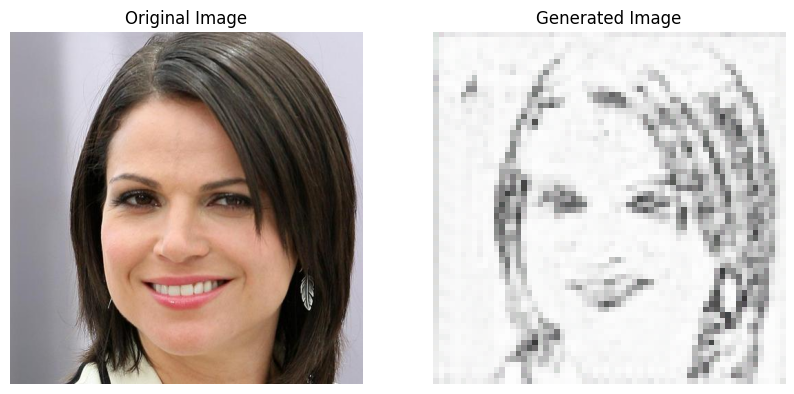

In [37]:
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


# Function to load and preprocess the image
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Resize to the input size of your model
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

# Function to denormalize the generated image
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # Scale from [-1, 1] to [0, 1]
    return tensor.clamp(0, 1)  # Ensure values are within [0, 1]

# Function to generate an image from a sketch
def generate_image_from_sketch(sketch_path, model):
    sketch_tensor = load_image(sketch_path).to(device)
    with torch.no_grad():
        generated_image = model(sketch_tensor)  # Generate image using the model
    generated_image = denormalize(generated_image.squeeze(0))  # Remove batch dimension and denormalize
    return transforms.ToPILImage()(generated_image.cpu())  # Convert to PIL image

# Example usage
sketch_path = '/content/dataset/test/photos/1020.jpg'  # Replace with your sketch image path
generated_image = generate_image_from_sketch(sketch_path, G)  # G is your generator model

# Display the original and generated images side by side
plt.figure(figsize=(10, 5))

original_image = Image.open(sketch_path).convert('RGB')

# Display original image
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.axis('off')
plt.title('Original Image')

# Display generated image
plt.subplot(1, 2, 2)
plt.imshow(generated_image)
plt.axis('off')
plt.title('Generated Image')


plt.show()

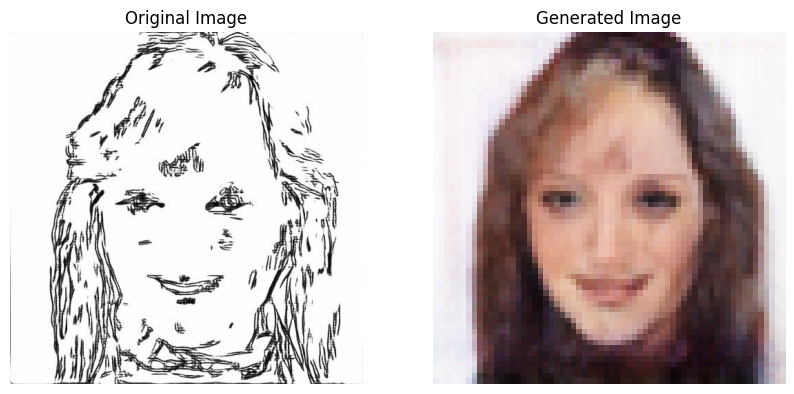

In [40]:
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


# Function to load and preprocess the image
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Resize to the input size of your model
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

# Function to denormalize the generated image
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # Scale from [-1, 1] to [0, 1]
    return tensor.clamp(0, 1)  # Ensure values are within [0, 1]

# Function to generate an image from a sketch
def generate_image_from_sketch(sketch_path, model):
    sketch_tensor = load_image(sketch_path).to(device)
    with torch.no_grad():
        generated_image = model(sketch_tensor)  # Generate image using the model
    generated_image = denormalize(generated_image.squeeze(0))  # Remove batch dimension and denormalize
    return transforms.ToPILImage()(generated_image.cpu())  # Convert to PIL image

# Example usage
sketch_path = '/content/dataset/test/sketches/10132.jpg'  # Replace with your sketch image path
generated_image = generate_image_from_sketch(sketch_path, F)  # G is your generator model

# Display the original and generated images side by side
plt.figure(figsize=(10, 5))

original_image = Image.open(sketch_path).convert('RGB')

# Display original image
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.axis('off')
plt.title('Original Image')

# Display generated image
plt.subplot(1, 2, 2)
plt.imshow(generated_image)
plt.axis('off')
plt.title('Generated Image')


plt.show()

In [34]:
!wget -q -O - ipv4.icanhazip.com

35.196.118.133


In [36]:
!streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.196.118.133:8501

your url is: https://tame-hairs-hide.loca.lt
/content/app.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full